<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Neural Networks with TensorFlow


---

### Learning Objectives
- Get a quick overview of TensorFlow
- Build a Multilayer Perceptron feed-forward network for regression and classification

## Common Neural Network libraries in Python
---

There are a number of libraries available for neural networks in Python, including:

- [Tensorflow](https://www.tensorflow.org/)
- [Pytorch](https://pytorch.org)
- [Caffe](http://caffe.berkeleyvision.org/)
- [Theano](http://deeplearning.net/software/theano/)
- [Keras](https://keras.io/)

We'll be using the Tensorflow library (by Google) in these examples.
Tensorflow is a library which can do many things beyond neural networks. Its main purpose is to facilitate using more powerful tools like GPUs or distributing calculations across clusters. A particular ingredient is the organization of calculations into computational graphs. These graphs are set up in python and then passed over to C++ to do the calculations.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.linear_model import LinearRegression

In [3]:
import tensorflow as tf

## Regression Example

### Load the Boston housing data

In [4]:
data = load_boston()
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.2, random_state=1)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Fit scikit-learn linear regression

In [5]:
lr = LinearRegression()
lr.fit(X_train, y_train)
mean_squared_error(y_test, lr.predict(X_test))

23.38083648027022

### Fit a tensorflow-keras model

We define a feed-forward neural network by setting up a sequence of dense layers which means that all nodes in the current layer are going to be connected to all nodes in the previous and the following layer. Only for the first layer we have to make the number of inputs explicit.

We can choose the type of activation function for each layer. For regression, the last layer has only one node and the identity as activation function.

We can specify which optimization algorithm we want to choose, which loss function we want to minimize and how we want to score our predictions.

In [6]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(8, activation='relu', 
                          input_shape=(data.data.shape[1], )),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

model.compile(loss='mse',
              optimizer=optimizer,
              metrics=['mse'])

After constructing the model we can get nice summaries.

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 112       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 337
Trainable params: 337
Non-trainable params: 0
_________________________________________________________________


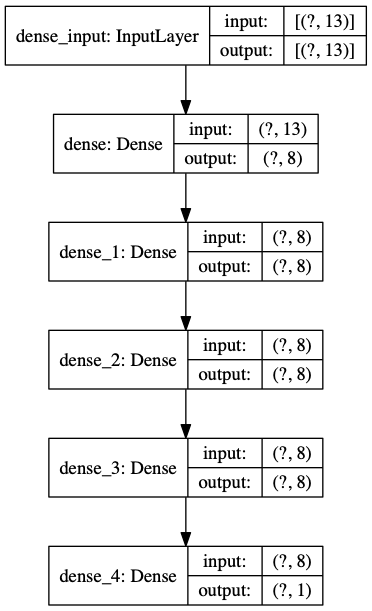

In [8]:
tf.keras.utils.plot_model(model, "boston_model.png", show_shapes=True)

To fit the model, we define how many iteration steps we would like to run at most and we use additionally an early stopping rule.

In [9]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)

EPOCHS = 1000

history = model.fit(
  X_train, y_train,
  epochs=EPOCHS, validation_split=0.2, verbose=0, callbacks=[early_stop])

We can check the value of the loss function on the training and validation set during each iteration.

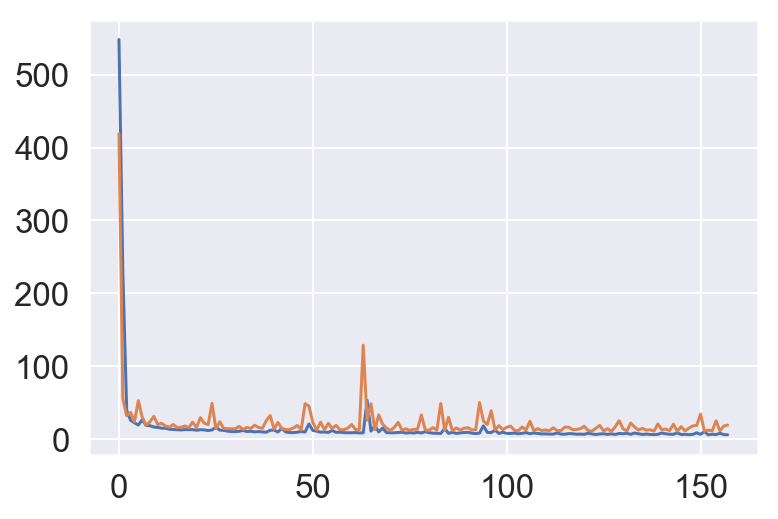

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

We can get the predicted values and scores.

In [11]:
predicitions = model.predict(X_test)

In [12]:
mean_squared_error(y_test, predicitions)

16.072713838324763

## Classification model

### Load the titanic dataset

In [13]:
data = pd.read_csv('datasets/titanic_train.csv')
X = data.drop('Survived', axis=1)
y = data[['Survived']]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

### Construct a pipeline

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer as Imputer
from sklearn.preprocessing import LabelBinarizer
from sklearn.pipeline import make_pipeline, make_union

# Create a helper class to extract features one by one in a pipeline
class FeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column].values.reshape(-1, 1)


FeatureExtractor('Fare').fit_transform(X_train)[0:5]

array([[51.8625],
       [15.5   ],
       [41.5792],
       [14.4542],
       [10.5167]])

The sklearn `LabelBinarizer` does not fit in a pipeline, let's use [this](https://github.com/scikit-learn/scikit-learn/issues/3112) customized version instead:

In [15]:
from sklearn.base import BaseEstimator


class CustomBinarizer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X):
        X = LabelBinarizer().fit_transform(X)
        if X.shape[1] > 1:
            return X[:, 1:]
        else:
            return X

binarizer = CustomBinarizer()
binarizer.fit_transform(X_train[['Embarked']].dropna())[:5]

array([[0, 1],
       [1, 0],
       [0, 0],
       [0, 0],
       [0, 1]])

In [16]:
# Create a pipeline to binarize labels and impute missing values with an appropriate method
pclass_pipe = make_pipeline(
    FeatureExtractor('Pclass'),
    Imputer(strategy='most_frequent'),
    CustomBinarizer(), 
    StandardScaler()
)
embarked_pipe = make_pipeline(
    FeatureExtractor('Embarked'),
    Imputer(strategy='most_frequent'),
    CustomBinarizer(),
    StandardScaler()
)
sex_pipe = make_pipeline(
    FeatureExtractor('Sex'),
    Imputer(strategy='most_frequent'),
    CustomBinarizer(),
    StandardScaler()
)
age_pipe = make_pipeline(
    FeatureExtractor('Age'),
    Imputer(strategy='mean'),
    StandardScaler()
)
sibsp_pipe = make_pipeline(
    FeatureExtractor('SibSp'),
    Imputer(strategy='most_frequent'),
    StandardScaler()
)
parch_pipe = make_pipeline(
    FeatureExtractor('Parch'),
    Imputer(strategy='most_frequent'),
    StandardScaler()
)
fare_pipe = make_pipeline(
    FeatureExtractor('Fare'),
    Imputer(strategy='most_frequent'),
    StandardScaler()
)

fu = make_union(pclass_pipe, sex_pipe, embarked_pipe,
                age_pipe, sibsp_pipe, parch_pipe, fare_pipe)

print(fu.fit_transform(X_train)[0:5])

[[-5.15162869e-01 -1.13679712e+00  7.26777220e-01 -3.12419419e-01
   6.00608519e-01  1.89224729e+00 -4.69836639e-01 -4.63992642e-01
   3.87841854e-01]
 [-5.15162869e-01  8.79664438e-01  7.26777220e-01  3.20082537e+00
  -1.66497805e+00 -2.74683674e-16 -4.69836639e-01 -4.63992642e-01
  -3.19080535e-01]
 [ 1.94113369e+00 -1.13679712e+00  7.26777220e-01 -3.12419419e-01
  -1.66497805e+00 -3.49933551e-01  3.44182654e-01  2.01618328e+00
   1.87924494e-01]
 [-5.15162869e-01  8.79664438e-01  7.26777220e-01 -3.12419419e-01
  -1.66497805e+00 -2.72616970e-01  3.44182654e-01 -4.63992642e-01
  -3.39411904e-01]
 [-5.15162869e-01  8.79664438e-01 -1.37593746e+00 -3.12419419e-01
   6.00608519e-01 -5.81883293e-01 -4.69836639e-01 -4.63992642e-01
  -4.15960736e-01]]


In [17]:
X_train = fu.transform(X_train)
X_test = fu.transform(X_test)

In [18]:
X_train.shape

(596, 9)

### Construct the tensorflow-keras model

In [19]:
np.unique(y_train)

array([0, 1])

In [20]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(8, activation='relu', 
                          input_shape=(X_train.shape[1], )),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(len(np.unique(y_train)), activation='softmax')
])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 8)                 80        
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 18        
Total params: 314
Trainable params: 314
Non-trainable params: 0
_________________________________________________________________


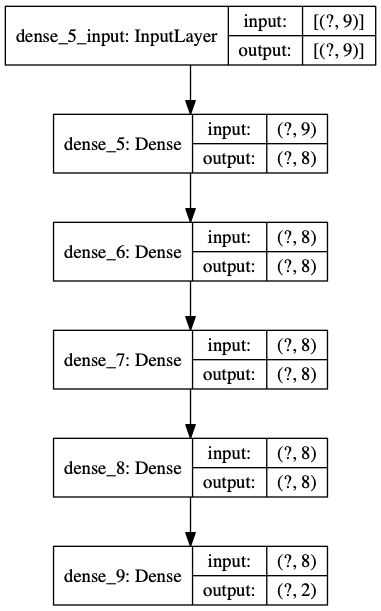

In [22]:
tf.keras.utils.plot_model(model, "titanic_model.png", show_shapes=True)

Fit the model:

In [23]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)

EPOCHS = 1000

history = model.fit(
  X_train, y_train.values,
  epochs=EPOCHS, validation_split = 0.2, verbose=0, callbacks=[early_stop])

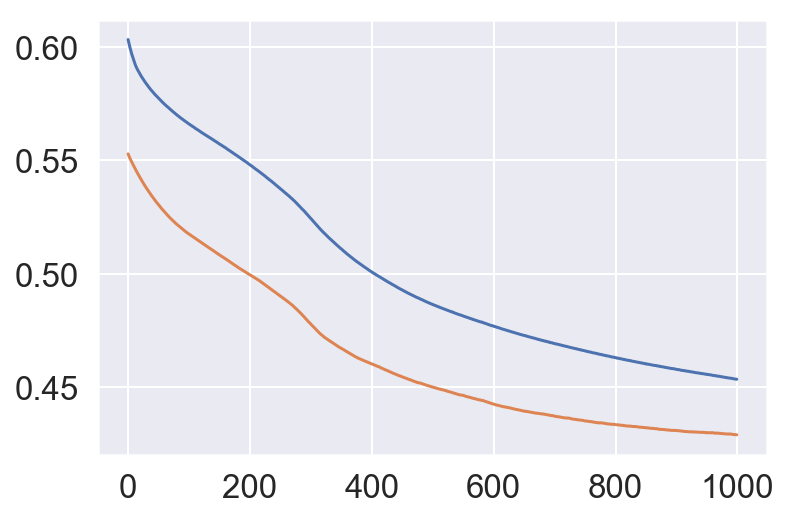

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

Get the predictions and scores.

In [25]:
predicitions = model.predict(X_test)

In [26]:
model.metrics_names

['loss', 'accuracy']

In [27]:
model.evaluate(X_test, y_test.values, verbose=2)

295/295 - 0s - loss: 0.4282 - accuracy: 0.8339


[0.4282237050896984, 0.8338983]

In [28]:
accuracy_score(y_test, predicitions.argmax(axis=1))

0.8338983050847457

### With Regularization

#### L2-regularization

We can use our usual L2-regularization by adding a penalty term to our loss function.

In [29]:
alpha = 0.001
model = tf.keras.Sequential([
    tf.keras.layers.Dense(8, activation='relu', 
                          input_shape=(X_train.shape[1], ), 
                          kernel_regularizer=tf.keras.regularizers.l2(alpha)),
    tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(alpha)),
    tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(alpha)),
    tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(alpha)),
    tf.keras.layers.Dense(2, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(alpha))
])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 8)                 80        
_________________________________________________________________
dense_11 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_13 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 18        
Total params: 314
Trainable params: 314
Non-trainable params: 0
_________________________________________________________________


In [30]:
tf.keras.utils.plot_model(model, "titanic_model.png", show_shapes=True)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)

EPOCHS = 1000

history = model.fit(
  X_train, y_train.values,
  epochs=EPOCHS, validation_split = 0.2, verbose=0, callbacks=[early_stop])

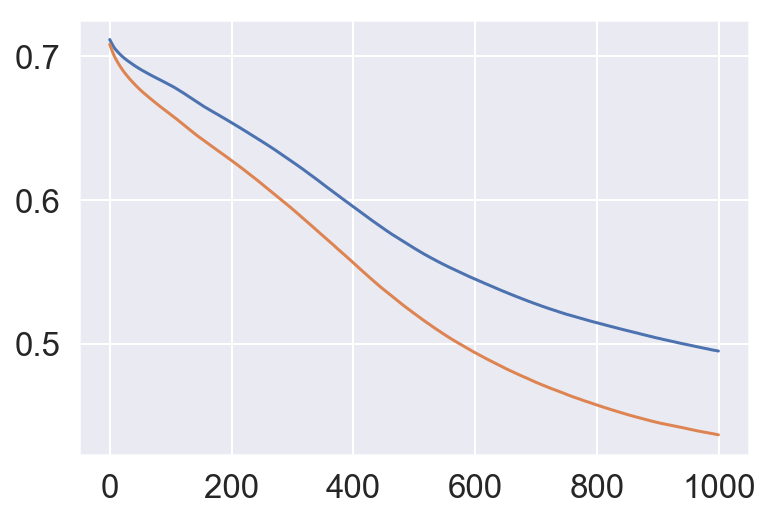

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [32]:
predicitions = model.predict(X_test)

In [33]:
model.metrics_names

['loss', 'accuracy']

In [34]:
model.evaluate(X_test, y_test.values, verbose=2)

295/295 - 0s - loss: 0.4968 - accuracy: 0.7898


[0.4968271343384759, 0.7898305]

In [35]:
accuracy_score(y_test, predicitions.argmax(axis=1))

0.7898305084745763

#### With dropout

Another popular regularization technique is dropout. Here, during each iteration step a fraction of nodes (defined through the dropout rate) are removed from the neural network, in that way not letting some nodes dominate the predictions.

Both regularization techniques can be mixed.

In [36]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(8, activation='relu', 
                          input_shape=(X_train.shape[1], )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2, activation='softmax')
])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 8)                 80        
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 72        
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_17 (Dense)             (None, 8)                 72        
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_18 (Dense)             (None, 8)                

In [37]:
tf.keras.utils.plot_model(model, "titanic_model.png", show_shapes=True)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)

EPOCHS = 1000

history = model.fit(
  X_train, y_train.values,
  epochs=EPOCHS, validation_split = 0.2, verbose=0, callbacks=[early_stop])

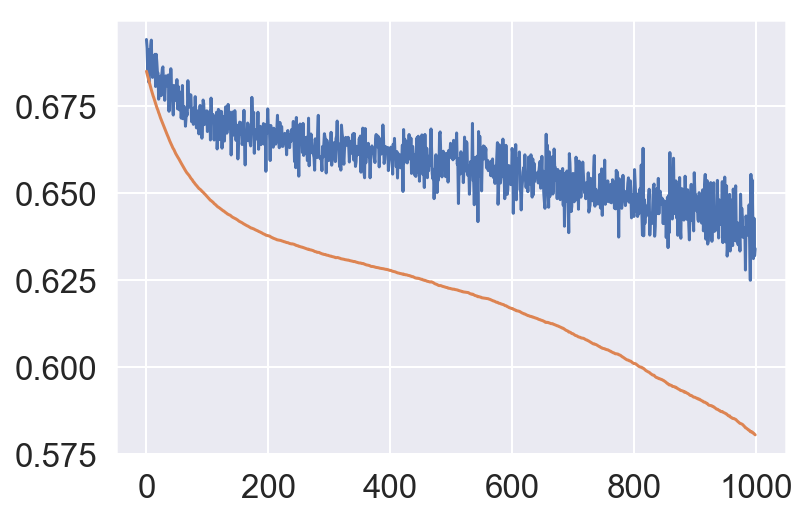

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [39]:
predicitions = model.predict(X_test)

In [40]:
model.metrics_names

['loss', 'accuracy']

In [41]:
model.evaluate(X_test, y_test.values, verbose=2)

295/295 - 0s - loss: 0.6250 - accuracy: 0.5932


[0.6249659847404997, 0.59322035]

In [42]:
accuracy_score(y_test, predicitions.argmax(axis=1))

0.5932203389830508

## Experiment

- Tune regression and classification models by adjusting the regularization scheme
- Play around with different [optimizers](https://www.tensorflow.org/api_docs/python/tf/optimizers)
- Play around with different [initialization schemes](https://www.tensorflow.org/api_docs/python/tf/initializers)
- Play around with different [activation functions](https://www.tensorflow.org/api_docs/python/tf/keras/activations)

## Additional Resources
---

- [Neural Networks and Deep Learning](http://neuralnetworksanddeeplearning.com/chap1.html)
- [Deep Learning](http://www.deeplearningbook.org/)
- [Tensorflow Tutorials](https://github.com/pkmital/tensorflow_tutorials)
- [Awesome Tensorflow](https://github.com/jtoy/awesome-tensorflow)
- [Tensorflow Examples](https://github.com/aymericdamien/TensorFlow-Examples)
- [Hands-on Machine Learning with ScikitLearn and TensorFlow](https://github.com/ageron/handson-ml)
- [Mind: How to Build a Neural Network](https://stevenmiller888.github.io/mind-how-to-build-a-neural-network/)